In [1]:
# Env: rive
# Audrey / Cindy /
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy import stats
import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
import calendar
import os
import tensorflow as tf # Machine learning

2024-01-11 14:06:37.822260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
import tensorflow.keras.backend as K
import pandas as pd
import numpy as np

# Chargement des librairies + données
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
echantillons = pd.read_csv("../AtlasDeLEau/qualite_eau_complet.csv", dtype={'no_labo': 'string', 'no_station': 'string'})

In [4]:
echantillons

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,V-S (mg/l),ZN-S (mg/l),P-T-660 (µg/l),CF-C (UFC/100 ml),AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l)
0,74390,220,0000097A,2000-05-16T00:00:00Z,1145,NaN,NaN,130.0,1.70,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,76610,220,0000097A,2000-06-19T00:00:00Z,1240,NaN,NaN,70.0,1.95,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,78452,220,0000097A,2000-07-11T00:00:00Z,1450,NaN,NaN,270.0,1.50,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,82191,220,0000097A,2000-08-15T00:00:00Z,1430,NaN,NaN,170.0,1.56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,85252,220,0000097A,2000-09-20T00:00:00Z,1215,NaN,NaN,340.0,1.08,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132717,Q120594-63,210,07710001,2020-07-14T00:00:00Z,1326,NaN,10.0,260.0,1.98,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132718,Q121526-38,210,07710001,2020-08-11T00:00:00Z,1627,NaN,12.0,900.0,1.60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132719,Q122605-93,210,07710001,2020-09-15T00:00:00Z,9999,NaN,15.0,100.0,1.40,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132720,Q123335-18,210,07710001,2020-10-13T00:00:00Z,1600,NaN,10.0,11.0,0.56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
cible = "turb"

#echantillons = pd.read_csv("../AtlasDeLEau/qualite_eau_complet.csv")
echantillons = pd.read_csv("../AtlasDeLEau/qualite_eau_complet.csv", dtype={'no_labo': 'string', 'no_station': 'string'})


qualite_eau = echantillons.copy()
qualite_eau['annee'] = pd.to_datetime(qualite_eau['date']).dt.year
qualite_eau['mois'] = pd.to_datetime(qualite_eau['date']).dt.month
qualite_eau = qualite_eau[(qualite_eau['mois'] >= 6) & (qualite_eau['mois'] <= 9) & (qualite_eau['annee'] >= 2016)]
qualite_eau['ID'] = qualite_eau['no_station'].astype(str) + "_" + qualite_eau['annee'].astype(str)
qualite_eau['nom_fichier'] = qualite_eau['ID'] + ".png"
qualite_eau = qualite_eau.dropna(subset=[cible])
qualite_eau[cible] = StandardScaler().fit_transform(qualite_eau[[cible]])

In [6]:
qualite_eau[cible]

19812    -0.224416
19813     0.038005
19814     0.084044
19819     0.130083
19820     1.373133
            ...   
132713    0.222161
132714    0.038005
132717    0.820666
132718    0.728589
132719   -0.026449
Name: turb, Length: 9372, dtype: float64

In [25]:
qualite_eau

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
19812,Q111972-99,210,06130005,2019-06-10T00:00:00Z,1000,NaN,18.0,3.0,4.73,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,6,06130005_2019,06130005_2019.png
19813,Q113254-06,210,06130005,2019-07-15T00:00:00Z,1010,NaN,27.0,5.0,4.51,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,7,06130005_2019,06130005_2019.png
19814,Q114228-99,210,06130005,2019-08-06T00:00:00Z,950,NaN,27.0,52.0,3.17,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,06130005_2019,06130005_2019.png
19819,Q120460-13,210,06130005,2020-07-13T00:00:00Z,1015,NaN,26.0,52.0,4.58,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,06130005_2020,06130005_2020.png
19820,Q122442-21,210,06130005,2020-09-14T00:00:00Z,700,NaN,27.0,84.0,4.58,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,06130005_2020,06130005_2020.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132713,Q114611-97,210,07710001,2019-08-13T00:00:00Z,912,NaN,15.0,430.0,2.28,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,07710001_2019,07710001_2019.png
132714,Q115919-20,210,07710001,2019-09-18T00:00:00Z,845,NaN,17.0,54.0,2.06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,9,07710001_2019,07710001_2019.png
132717,Q120594-63,210,07710001,2020-07-14T00:00:00Z,1326,NaN,10.0,260.0,1.98,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,07710001_2020,07710001_2020.png
132718,Q121526-38,210,07710001,2020-08-11T00:00:00Z,1627,NaN,12.0,900.0,1.60,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,07710001_2020,07710001_2020.png


In [10]:
# Préparation des générateurs d'images
dossier_images = "../Imagerie/3km/"
colonne_noms_fichiers = "nom_fichier"
rescale_factor = 1/255
validation_fraction = 0.2
image_dimensions = (294, 201)
random_seed = int(np.round(np.random.uniform(0, 10000)))

train_data, val_data = train_test_split(qualite_eau, test_size=validation_fraction, random_state=random_seed)

In [14]:
train_data

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
126528,Q099004-12,210,03090047,2017-09-05T00:00:00Z,1020,NaN,NaN,440.0,1.57,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,9,03090047_2017,03090047_2017.png
71051,Q120466-02,230,05080100,2020-07-13T00:00:00Z,755,NaN,NaN,4800.0,1.76,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,05080100_2020,05080100_2020.png
131919,Q114732-37,210,05030001,2019-08-19T00:00:00Z,912,NaN,2.6,28.0,1.39,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,8,05030001_2019,05030001_2019.png
128338,Q106988-37,210,03030026,2018-09-04T00:00:00Z,1000,NaN,NaN,560.0,3.75,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,9,03030026_2018,03030026_2018.png
68145,Q121269-08,230,03030323,2020-08-03T00:00:00Z,1030,NaN,NaN,6000.0,8.13,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,03030323_2020,03030323_2020.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125615,Q098383-98,210,05300035,2017-08-15T00:00:00Z,1005,NaN,NaN,110.0,1.86,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,8,05300035_2017,05300035_2017.png
131658,Q111996-23,210,04050001,2019-06-10T00:00:00Z,1610,NaN,13.0,25.0,2.29,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2019,6,04050001_2019,04050001_2019.png
69771,Q122328-05,210,03090002,2020-09-08T00:00:00Z,1215,NaN,44.0,160.0,160.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,03090002_2020,03090002_2020.png
131769,Q120646-03,210,04310011,2020-07-14T00:00:00Z,1300,NaN,6.4,140.0,3.59,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,7,04310011_2020,04310011_2020.png


In [12]:
val_data

,no_labo,no_projet,no_station,date,heure,alc,cat,cf,chl_aa,clo,...,AS (mg/l),PHE (µg/l),TAN (mg/l),AG (mg/l),U (mg/l),P-T-66V (µg/l),annee,mois,ID,nom_fichier
128717,Q107125-97,210,03040071,2018-09-05T00:00:00Z,1005,NaN,NaN,230.0,1.16,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,9,03040071_2018,03040071_2018.png
31736,Q096017-68,210,03030123,2017-06-05T00:00:00Z,920,NaN,NaN,94.0,3.98,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,6,03030123_2017,03030123_2017.png
130711,Q121188-09,210,03030023,2020-08-02T00:00:00Z,900,NaN,37.0,23.0,27.20,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,8,03030023_2020,03030023_2020.png
20472,Q106060-10,230,02360011,2018-08-06T00:00:00Z,1100,NaN,NaN,66.0,3.39,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2018,8,02360011_2018,02360011_2018.png
123158,Q096956-42,210,02340034,2017-07-04T00:00:00Z,1600,NaN,NaN,110.0,1.83,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2017,7,02340034_2017,02340034_2017.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71995,Q130269-36,210,05280001,2021-09-13T00:00:00Z,1020,NaN,7.2,230.0,1.47,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,9,05280001_2021,05280001_2021.png
130737,Q122264-16,210,03030026,2020-09-08T00:00:00Z,840,NaN,NaN,210.0,3.21,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2020,9,03030026_2020,03030026_2020.png
71041,Q129074-01,210,05080073,2021-08-09T00:00:00Z,1000,NaN,2.1,56.0,1.56,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2021,8,05080073_2021,05080073_2021.png
120945,Q090753-87,210,02260002,2016-08-15T00:00:00Z,1015,NaN,NaN,150.0,4.62,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2016,8,02260002_2016,02260002_2016.png


In [15]:
datagen = ImageDataGenerator(rescale=rescale_factor)

training_generator = datagen.flow_from_dataframe(
    train_data,
    directory=dossier_images,
    x_col=colonne_noms_fichiers,
    y_col=cible,
    target_size=image_dimensions,
    class_mode="other",
    #subset="training",
    seed=random_seed
)

validation_generator = datagen.flow_from_dataframe(
    val_data,
    directory=dossier_images,
    x_col=colonne_noms_fichiers,
    y_col=cible,
    target_size=image_dimensions,
    class_mode="other",
    #subset="validation",
    seed=random_seed
)

Found 7497 validated image filenames.
Found 1875 validated image filenames.


In [31]:
# Préparation et ajustement du modèle
model = Sequential([
    Conv2D(128, kernel_size=(3, 3), activation="relu", input_shape=(image_dimensions[0], image_dimensions[1], 3)),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(64, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),
    Conv2D(32, kernel_size=(3, 3), activation="relu"),
    MaxPooling2D(pool_size=(4, 4)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(1)
])

def r2(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 292, 199, 128)     3584      
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 73, 49, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 71, 47, 64)        73792     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 17, 11, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 15, 9, 32)         18464     
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 3, 2, 32)         

In [32]:
model.compile(optimizer="adam", loss="mse", metrics=["mae", r2])

In [33]:
# Exploration des résultats
history = model.fit(
    x=training_generator,
    validation_data=validation_generator,
    epochs=5
)

Epoch 1/5


2024-01-11 17:28:17.102148: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 952041472 exceeds 10% of free system memory.
2024-01-11 17:28:18.028212: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 952041472 exceeds 10% of free system memory.


  1/235 [..............................] - ETA: 17:48 - loss: 0.1915 - mae: 0.3387 - r2: -0.0923

2024-01-11 17:28:19.024715: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 952041472 exceeds 10% of free system memory.
2024-01-11 17:28:19.747455: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 952041472 exceeds 10% of free system memory.


  2/235 [..............................] - ETA: 6:56 - loss: 0.8839 - mae: 0.4374 - r2: -0.0635 

2024-01-11 17:28:20.813457: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 952041472 exceeds 10% of free system memory.


235/235 [==============================] - 455s 2s/step - loss: 0.9113 - mae: 0.4424 - r2: -0.1154 - val_loss: 1.3550 - val_mae: 0.5016 - val_r2: -0.2069
Epoch 2/5
235/235 [==============================] - 503s 2s/step - loss: 0.8757 - mae: 0.4225 - r2: -0.0788 - val_loss: 1.2565 - val_mae: 0.4293 - val_r2: 0.0769
Epoch 3/5
235/235 [==============================] - 503s 2s/step - loss: 0.7873 - mae: 0.3920 - r2: 0.0369 - val_loss: 1.2015 - val_mae: 0.4194 - val_r2: -0.2371
Epoch 4/5
235/235 [==============================] - 476s 2s/step - loss: 0.7461 - mae: 0.3775 - r2: 0.0289 - val_loss: 1.1711 - val_mae: 0.3838 - val_r2: 0.1072
Epoch 5/5
235/235 [==============================] - 532s 2s/step - loss: 0.7189 - mae: 0.3673 - r2: 0.0884 - val_loss: 1.1399 - val_mae: 0.3814 - val_r2: 0.1471


In [34]:
history.history

{'loss': [0.9112544059753418,
  0.8756878972053528,
  0.7873342037200928,
  0.746093213558197,
  0.7189088463783264],
 'mae': [0.44235408306121826,
  0.42254045605659485,
  0.3919554352760315,
  0.37745508551597595,
  0.3672521412372589],
 'r2': [-0.11542286723852158,
  -0.07878189533948898,
  0.03688143938779831,
  0.028865205124020576,
  0.08838459104299545],
 'val_loss': [1.3549591302871704,
  1.256500244140625,
  1.2015244960784912,
  1.1711448431015015,
  1.1398849487304688],
 'val_mae': [0.5016037225723267,
  0.42926475405693054,
  0.41936439275741577,
  0.3837636113166809,
  0.3813941478729248],
 'val_r2': [-0.2069181501865387,
  0.07685517519712448,
  -0.237113818526268,
  0.10716770589351654,
  0.1471066176891327]}

Text(0.5, 0.98, 'Predict turbidity from 3km images (M2)')

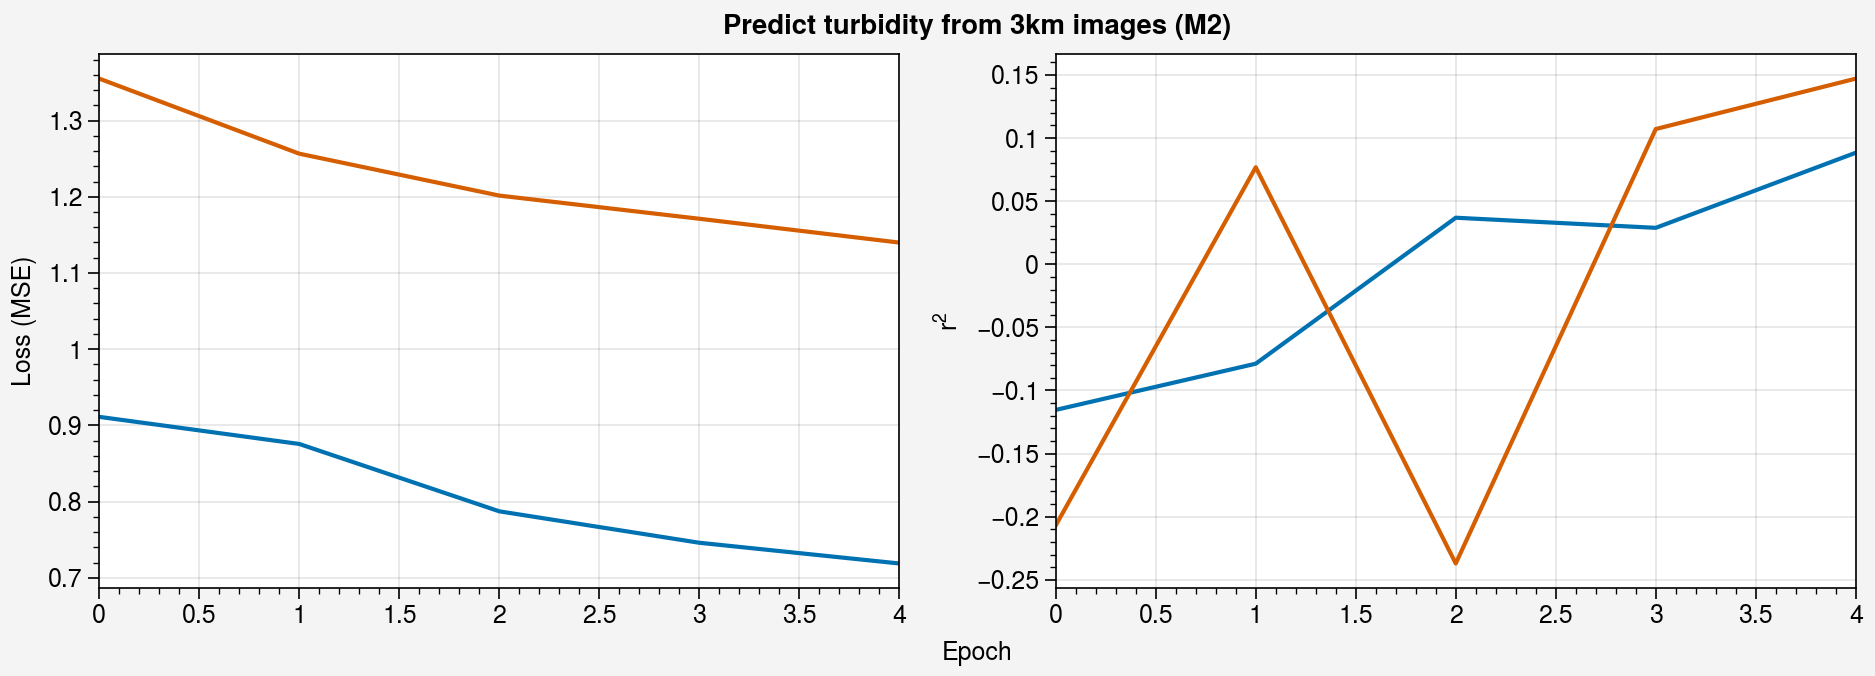

In [43]:
fig, axs = pplt.subplots(ncols=2, nrows=1, refwidth=4, sharey=0, refaspect=1.5)

axs[0].plot(history.history['loss'], label='training')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].format(xlabel='Epoch', ylabel='Loss (MSE)')

axs[1].plot(history.history['r2'], label='training')
axs[1].plot(history.history['val_r2'], label='validation')
axs[1].format(xlabel='Epoch', ylabel='$r^2$')

fig.suptitle('Predict turbidity from 3km images (M2)')

In [44]:
# Exploration des résultats
history2 = model.fit(
    x=training_generator,
    validation_data=validation_generator,
    epochs=15
)

Epoch 1/15
235/235 [==============================] - 885s 4s/step - loss: 0.6874 - mae: 0.3547 - r2: 0.1541 - val_loss: 1.1430 - val_mae: 0.3862 - val_r2: 0.1271
Epoch 2/15
235/235 [==============================] - 879s 4s/step - loss: 0.6790 - mae: 0.3503 - r2: 0.1190 - val_loss: 1.1020 - val_mae: 0.3766 - val_r2: 0.1217
Epoch 3/15
235/235 [==============================] - 834s 4s/step - loss: 0.6501 - mae: 0.3383 - r2: 0.1073 - val_loss: 1.1144 - val_mae: 0.4148 - val_r2: -0.1160
Epoch 4/15
235/235 [==============================] - 891s 4s/step - loss: 0.6405 - mae: 0.3380 - r2: 0.1702 - val_loss: 1.1090 - val_mae: 0.3758 - val_r2: 0.0356
Epoch 5/15
235/235 [==============================] - 887s 4s/step - loss: 0.6356 - mae: 0.3252 - r2: 0.1715 - val_loss: 1.1084 - val_mae: 0.3703 - val_r2: 0.0991
Epoch 6/15
235/235 [==============================] - 752s 3s/step - loss: 0.6281 - mae: 0.3276 - r2: 0.1979 - val_loss: 1.0832 - val_mae: 0.3989 - val_r2: 0.0162
Epoch 7/15
235/235 [=

In [ ]:
file_pi = 'qualite_eau_adam.pkl'

In [ ]:
with open('/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [ ]:
with open('/trainHistoryDict', "rb") as file_pi:
    history = pickle.load(file_pi)